In [ ]:
!pip install torch_geometric
!pip install torch_sparse
!pip install torch_scatter

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np 

class GCN(torch.nn.Module):
    def __init__(self,d,c):
        super().__init__()
        self.conv1 = GCNConv(d, 16)
        self.conv2 = GCNConv(16, c)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [8]:
from torch_geometric.datasets import Planetoid
n = 2708
c = 7
def run_gcn(train_size_per_class):
    test_size = n - c*train_size_per_class

    dataset = Planetoid(root='~/workspace/data/Cora', name='Cora',split='random',num_train_per_class=train_size_per_class,num_val=0, num_test=test_size)
    data = dataset[0]
    #print(sum(data.train_mask),sum(data.test_mask))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(dataset.num_node_features,dataset.num_classes).to(device)
    data = dataset[0].to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc
    #print(f'Accuracy: {acc:.4f}')

In [9]:
lst_ts = np.array([20,40,80,120,160,200])
trails = 10
all_outs = []
for ts in lst_ts:
    out = []
    for t in range(trails):
        acc = run_gcn(ts)
        #print(t,ts,acc)
        out.append(acc)
    all_outs.append(out)

[0.76028037 0.79526359 0.81936685 0.83372591 0.83986146 0.84174312] [0.01634791 0.01293855 0.01255603 0.01060228 0.01237225 0.01179453]


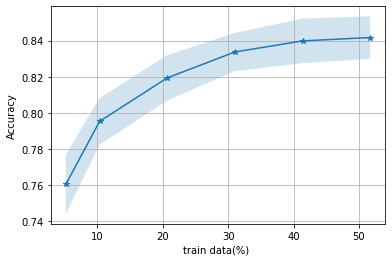

In [11]:
import matplotlib.pyplot as plt 
y = np.mean(all_outs,axis=1)
y_err = np.std(all_outs,axis=1)
print(y,y_err)
x_ticks = (lst_ts*c*100 )/n
plt.plot(x_ticks,y,marker='*')
plt.fill_between(x_ticks,y-y_err,y+y_err,alpha=0.2)
plt.ylabel('Accuracy')
plt.xlabel('train data(%) ')
plt.grid()